# Problem Description

In [27]:
"""


"""

'\n\n\n'

In [28]:
import pandas as pd 
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import string

from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.preprocessing.text import Tokenizer


from nltk.corpus import stopwords

#Print Options
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Read Data

In [29]:
#Reading Data

df_true = pd.read_csv("../data/True.csv")
df_fake = pd.read_csv("../data/Fake.csv")


In [30]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [31]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Data Cleaning

In [32]:
#Add column y to label each row into a particular class i.e. True/Fake, this coulumn would act as class label
df_true['y'] = 0 # 0 - True
df_fake['y'] = 1 # 1 - Fake



In [33]:
#Combine into one main dataframe
df = pd.concat([df_true,df_fake], ignore_index = True)
df.head()

,title,text,subject,date,y
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


## General Data Check

In [34]:
#Get General Info about the data

df.info()

'''
Conclusion: General data seems consistent as no obvious problems are visible, needs more indepth analysis
'''



#Check Duplicates

d_data = df['text'].duplicated()
df.loc[d_data].shape

'''
Conclusion: around 6252 rows of data are duplicates
'''


#Dropping Duplicates
df = df.drop_duplicates('text', keep='last')
df.reset_index(drop=True)





#Check Missing Values
df.isnull().sum()

'''
Conclusion: No values are Missing
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   y        44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


'\nConclusion: No values are Missing\n'

### Clean Date Column

In [35]:
'''
# Correct Date Data

Date coulumn would be important for data exploration, 
thus need to make sure its format is consistent and their is no noise present in the feature


'''


# Check for anamoly
#print(df['date'].unique())


'''
Conclusion:
- It can be noticed that there is  is white space in each value need to remove it
- It can be noticed that some values are not dates and can be considered noise 
'''





# Remove Whitespace
df['date'] = df['date'].str.strip()








# Remove rows where date is corrupted
# - Make Months in simillar format so dates and noise can be filtered out later
original_month = ['January','February','March','April','May','June','July','August','September','October','November','December']
new_month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in range(0,12):
    df['date'] = df['date'].str.replace(original_month[i],new_month[i])



# - Check length and remove rows which have more characters than regular date data
#print(df[df['date'].str.len() >12])
df.drop(df[df['date'].str.len() >12].index, inplace=True)
df['date']








#Convert to date_time object

df['date'] = df['date'].apply(lambda x: pd.to_datetime(x).strftime('%d/%m/%Y'))


'''#Conclusion: Now all the dates are DataTime Objects and follow consistent %d/%m/%Y format '''



#Create New Date related features for easier plotting







'#Conclusion: Now all the dates are DataTime Objects and follow consistent %d/%m/%Y format '

## Data Exploration

In [36]:
df.columns

Index(['title', 'text', 'subject', 'date', 'y'], dtype='object')

### Is the amount of fake data equal to the true data? 

True Shape:  (21191, 5)
Fake Shape:  (17449, 5)
3742


/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='y', ylabel='count'>

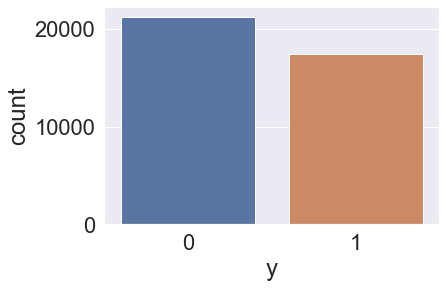

In [37]:
'''Check Class-wise Data Distribution'''

#Check Shape

#Comment on the number of rows in each section and how it may effect classificaiton

true_shape = df.loc[df['y']==0].shape
fake_shape = df.loc[df['y']==1].shape
print("True Shape: ",true_shape)
print("Fake Shape: ",fake_shape)

if true_shape > fake_shape:
    print(true_shape[0] - fake_shape[0])
else:
    print(fake_shape[0] - true_shape[0])

#Plot Frequency of each class
sns.countplot(df['y'])

In [38]:
"""
Conclusion: Roughly the same data size, so the sampling error would be negligable and can be ignored, 
thus no over/under sampling techenique needed.

"""

'\nConclusion: Roughly the same data size, so the sampling error would be negligable and can be ignored, \nthus no over/under sampling techenique needed.\n\n'

### Are certian subjects bias towards a type of news ? 

In [39]:
df['subject'].value_counts()

politicsNews       11202
worldnews           9989
News                9050
left-news           4302
politics            2358
Government News      956
Middle-east          778
US_News                5
Name: subject, dtype: int64

In [40]:
true = df[df['y']==0]
true['subject'].unique()

array(['politicsNews', 'worldnews'], dtype=object)

In [41]:
fake = df[df['y']==1]
fake['subject'].unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [42]:
# change politics to politicsNews as they are same labels 
df.subject=df.subject.replace({'politics':'politicsNews'})

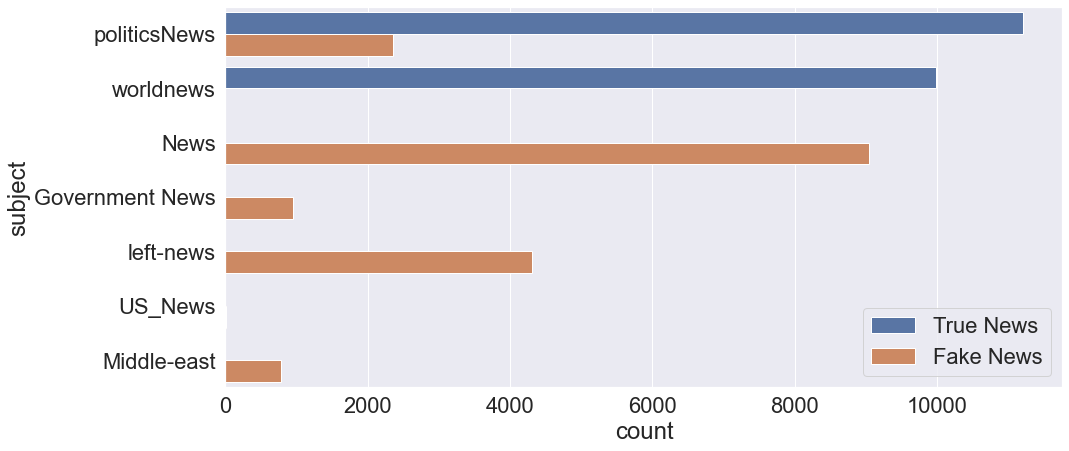

In [43]:
#Plotting out the Subject and its association with type of news
f, ax = plt.subplots(figsize=(15, 7))
sns.set_style("darkgrid")
sns.set(font_scale=2)
sns.countplot(y="subject", data=df, hue="y")
new_labels = ['True Data', 'Fake Data']
plt.legend(labels=['True News', 'Fake News'])

In [44]:
"""
Conclusion: There is no overlap of subjects between the 2 types of news, thus Subject is an 
independent variable and would not help to classify between the types of news. 

Needs to be removed later during feature processing.

"""

'\nConclusion: There is no overlap of subjects between the 2 types of news, thus Subject is an \nindependent variable and would not help to classify between the types of news. \n\nNeeds to be removed later during feature processing.\n\n'

### Is the Fake/True data related to certian time period?

In [45]:
#ratio of true and fake 

In [74]:
import datetime as dt
df['year'] = pd.to_datetime(df['date']).dt.to_period('Y')
df['month'] = pd.to_datetime(df['date']).dt.to_period('m')
df['month'] = df['month'].astype(str)
df_temp = df[['month', 'y']]
df_temp = df_temp.groupby(['month'])['y'].sum()

<AxesSubplot:xlabel='month'>

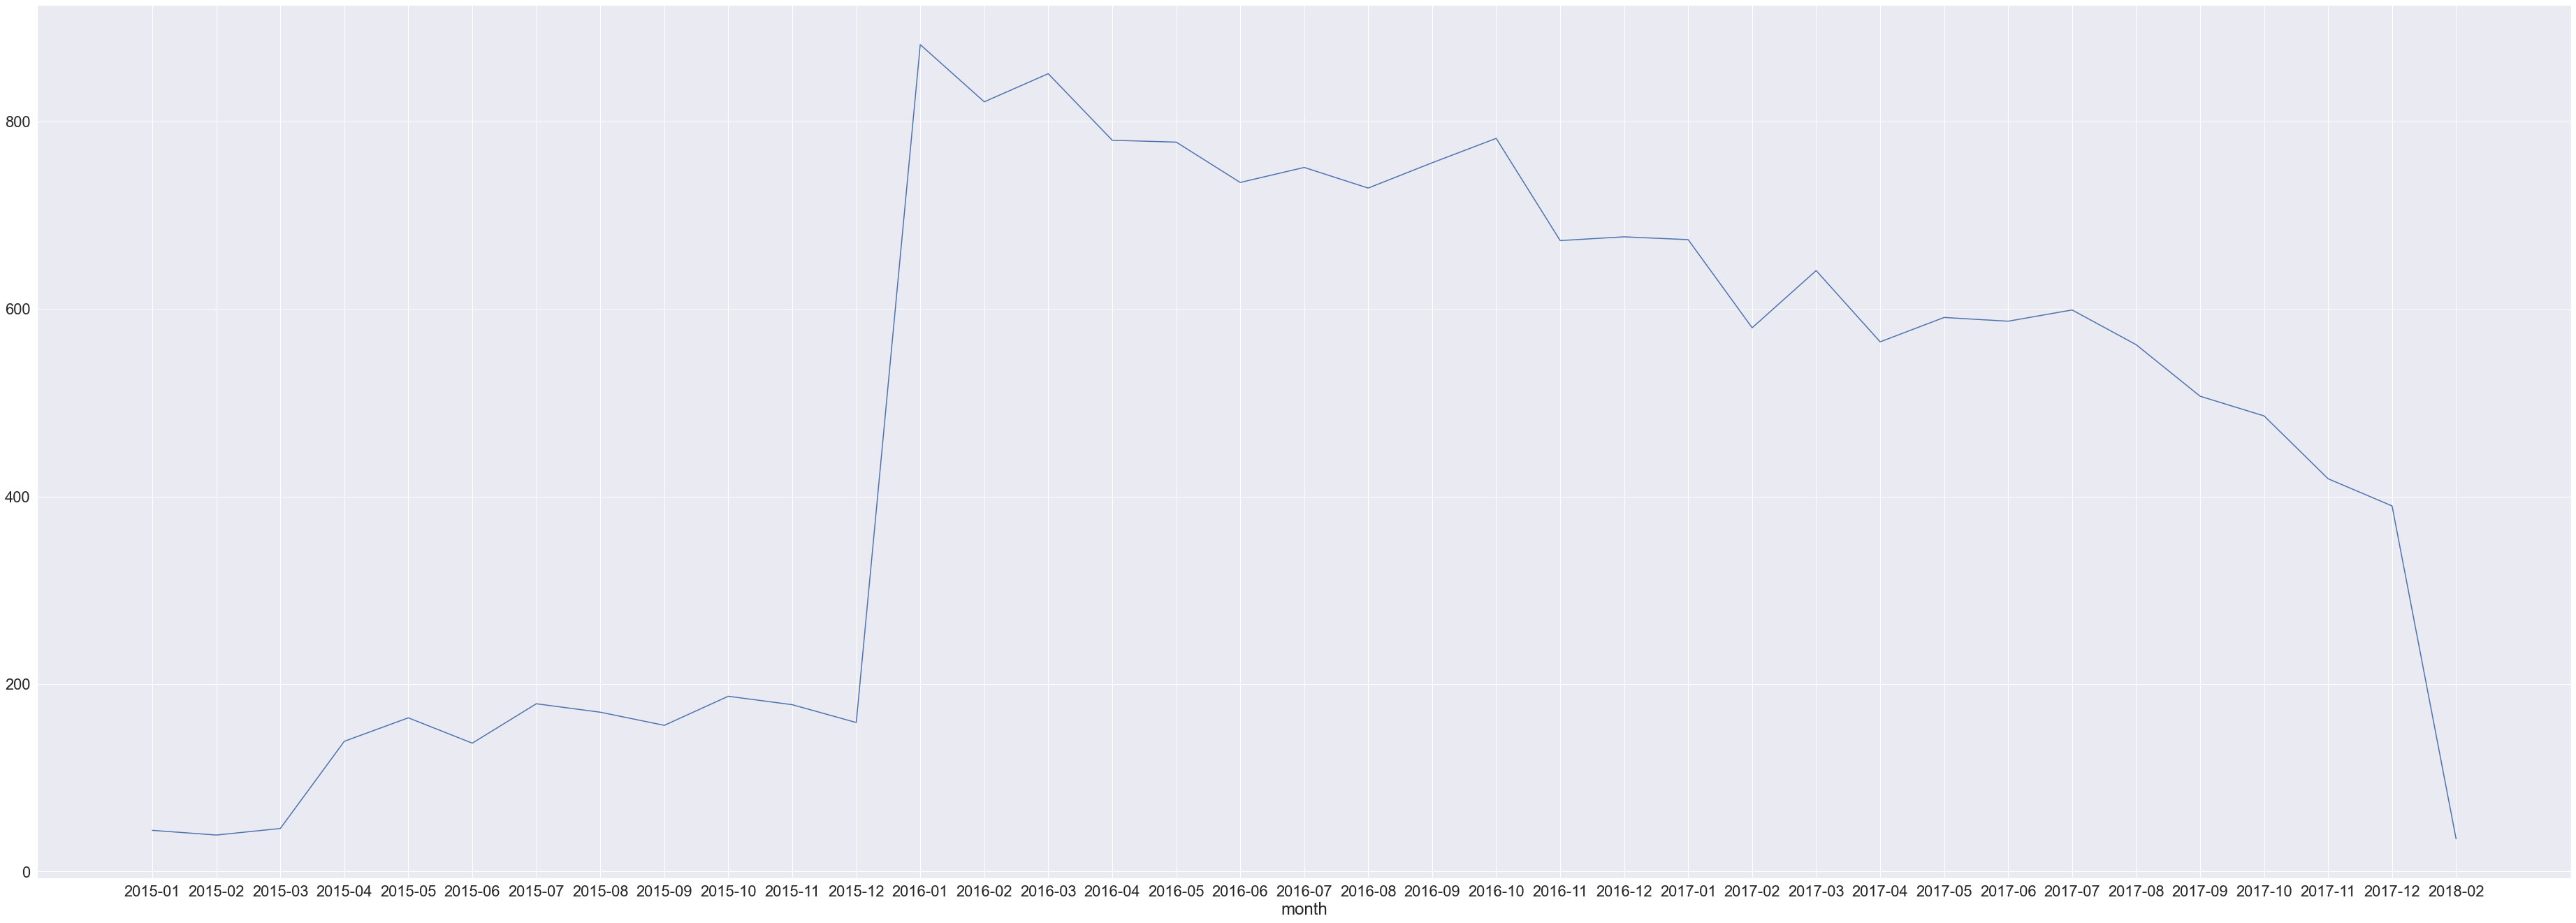

In [82]:
f, ax = plt.subplots(figsize=(65, 23))
sns.set_style("darkgrid")
sns.set(font_scale=2)
sns.lineplot(x=df_temp.index,y=df_temp.values, data=df_temp)

In [ ]:
"""
Conclusion: There is no overlap of subjects between the 2 types of news, thus Subject is an 
independent variable and would not help to classify between the types of news. 

Needs to be removed later during feature processing.

"""

### Title / Text word distribution based on type of news

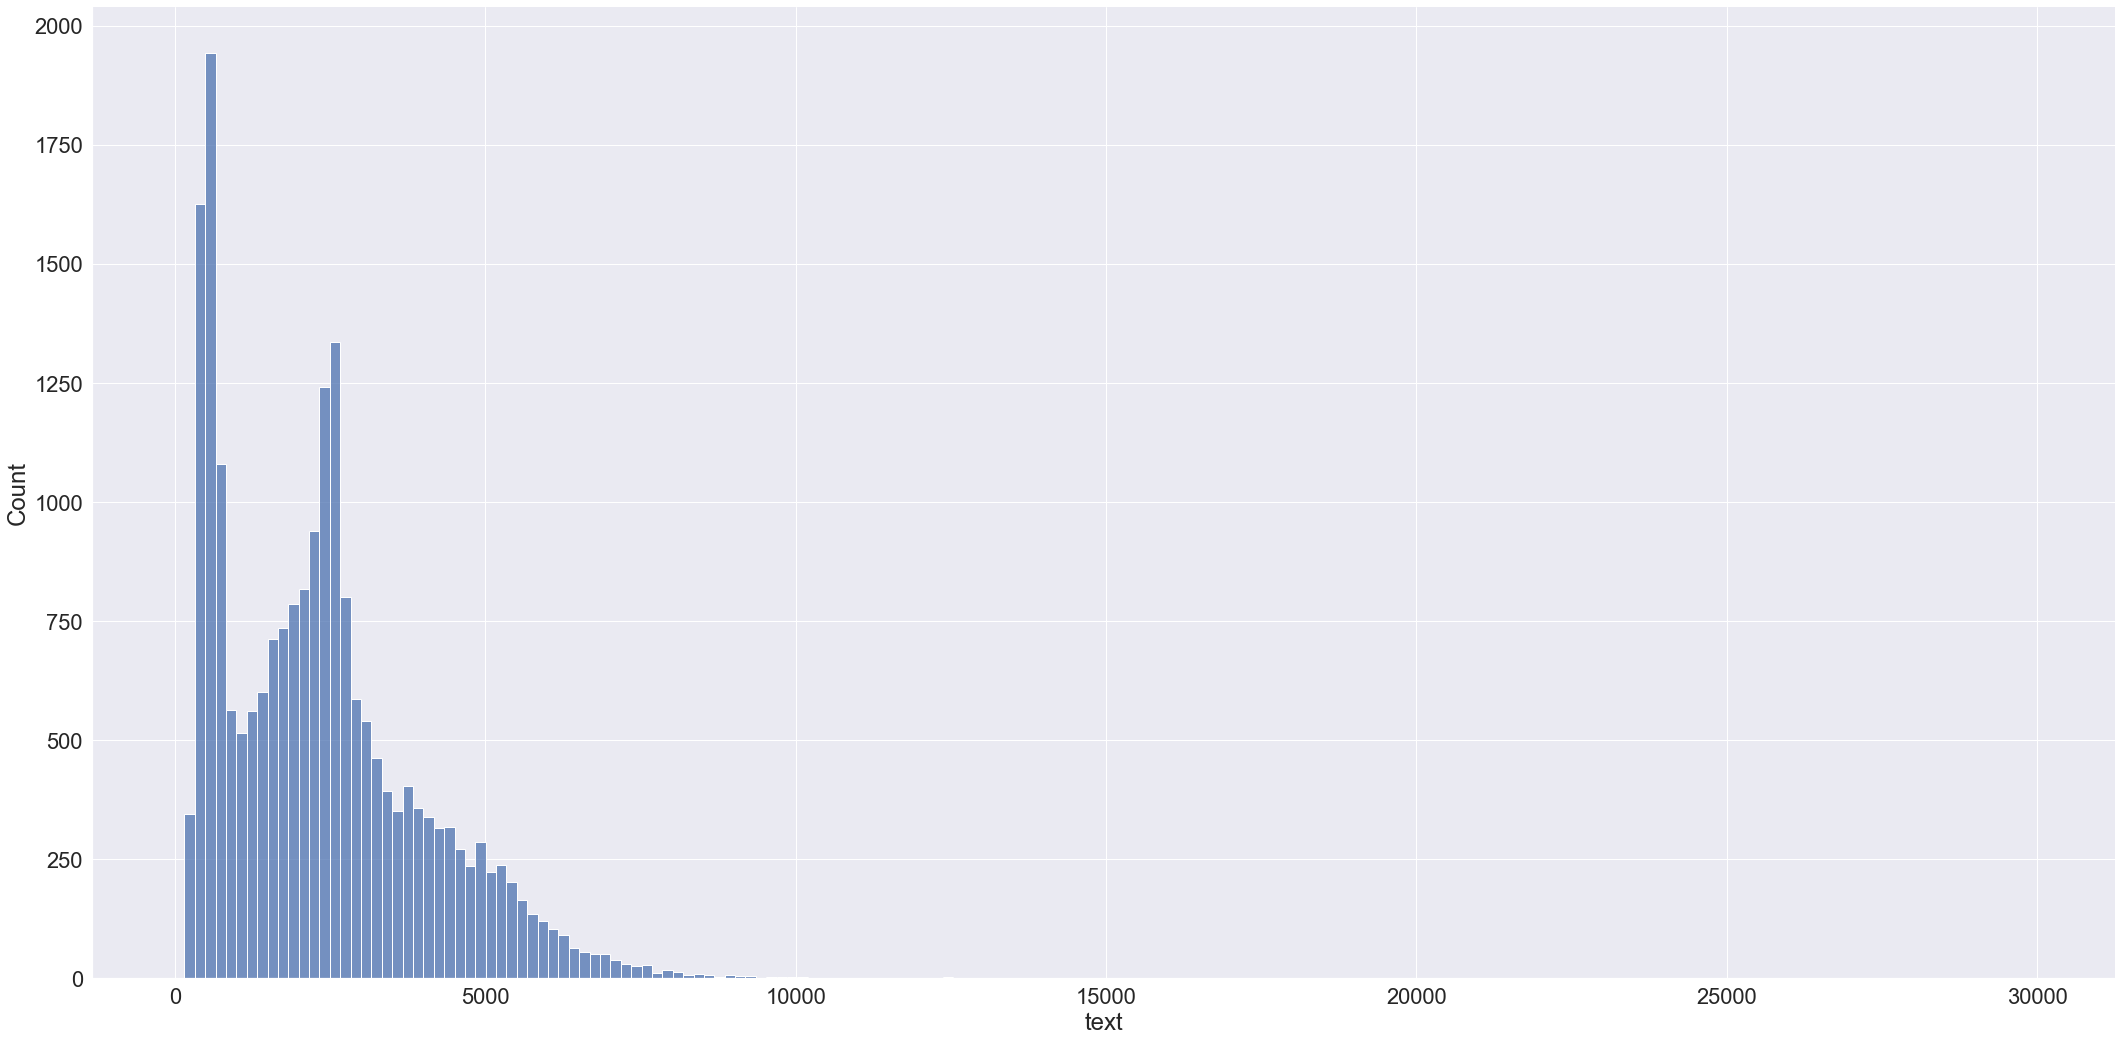

In [42]:
#Check number of characters in text , Fake v. True

true_text_len=df[df['y']==0]['text'].str.len()
fake_text_len=df[df['y']==1]['text'].str.len()


sns.displot(true_text_len,height=15, aspect=2)


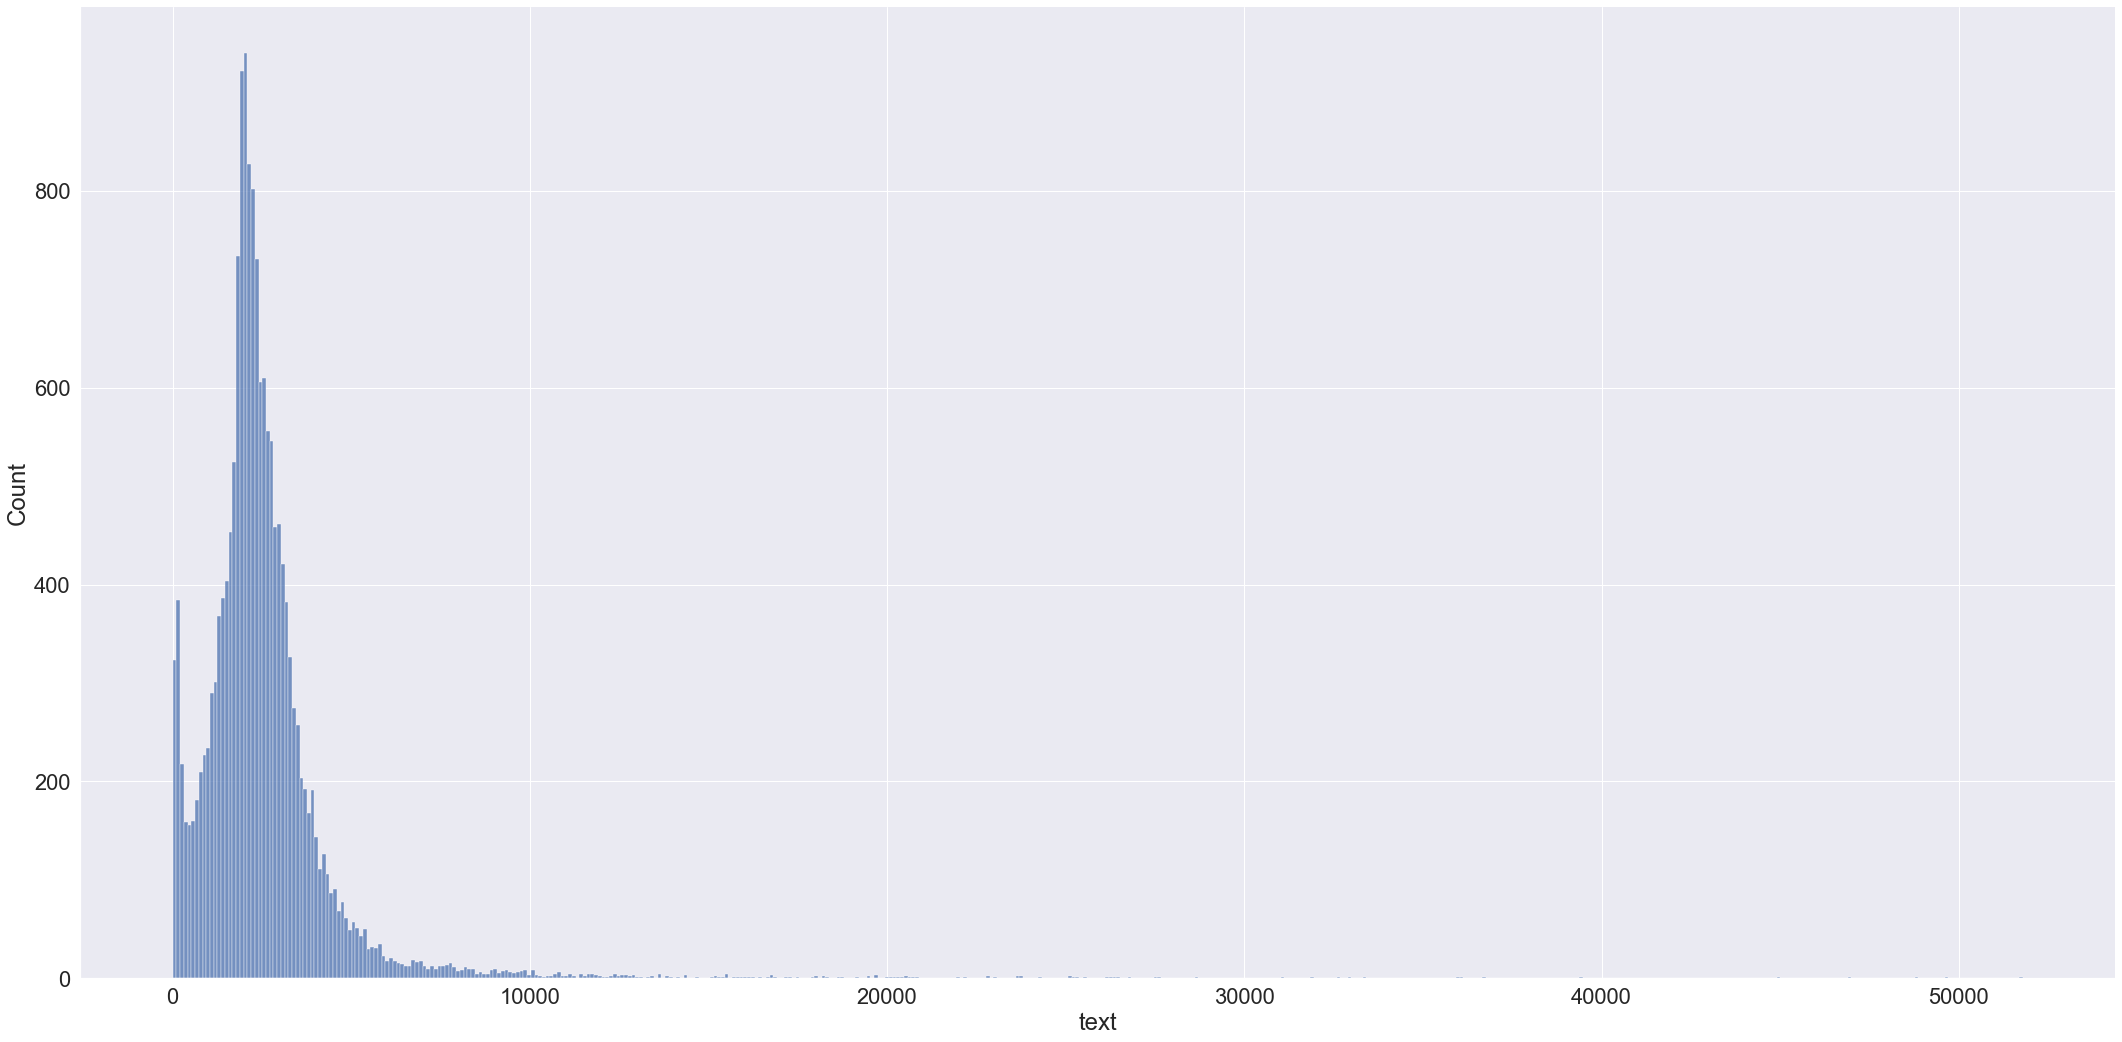

In [43]:
sns.displot(fake_text_len,height=15, aspect=2)

In [ ]:
"""

Conclusion - 

"""

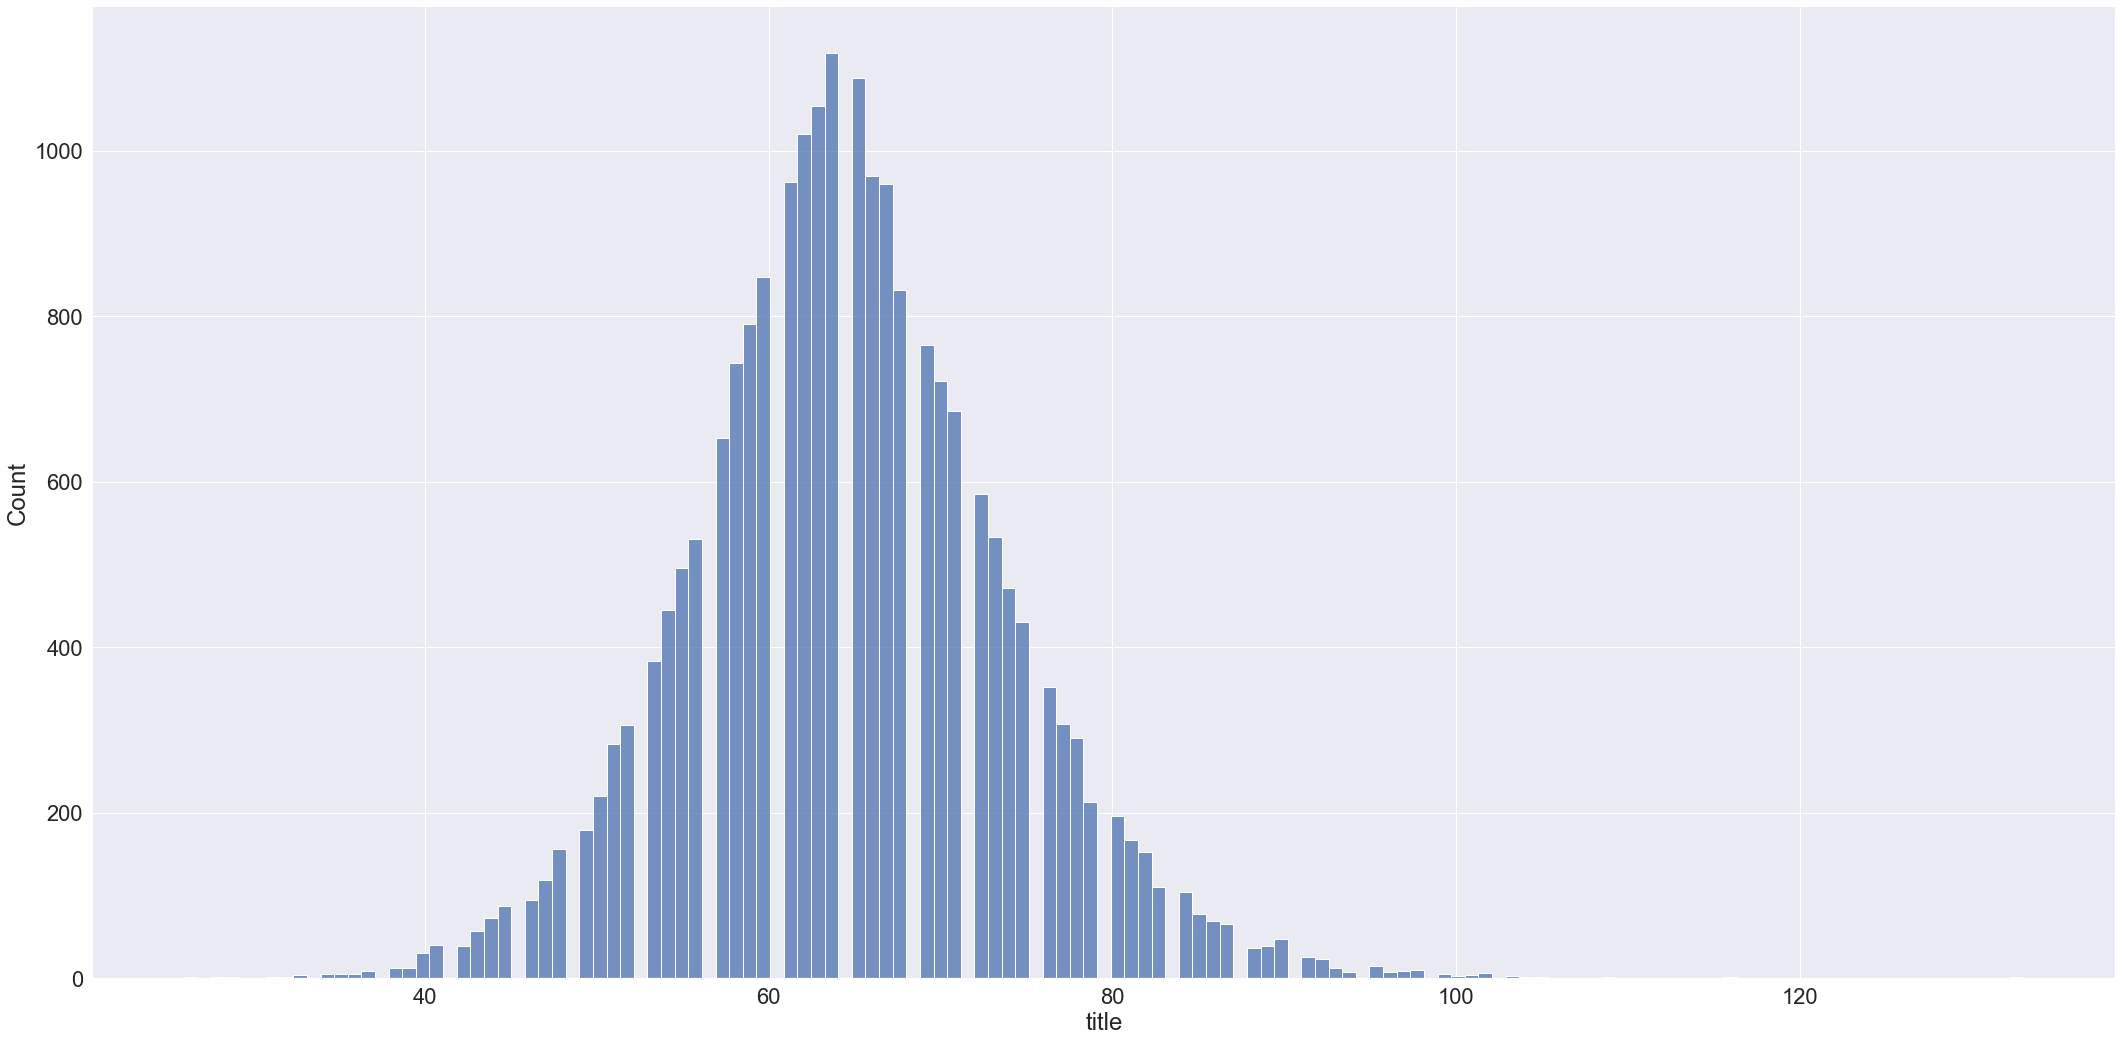

In [38]:
#Check number of characters in Title , Fake v. True

true_title_len=df[df['y']==0]['title'].str.len()
fake_title_len=df[df['y']==1]['title'].str.len()


sns.displot(true_title_len,height=15, aspect=2)


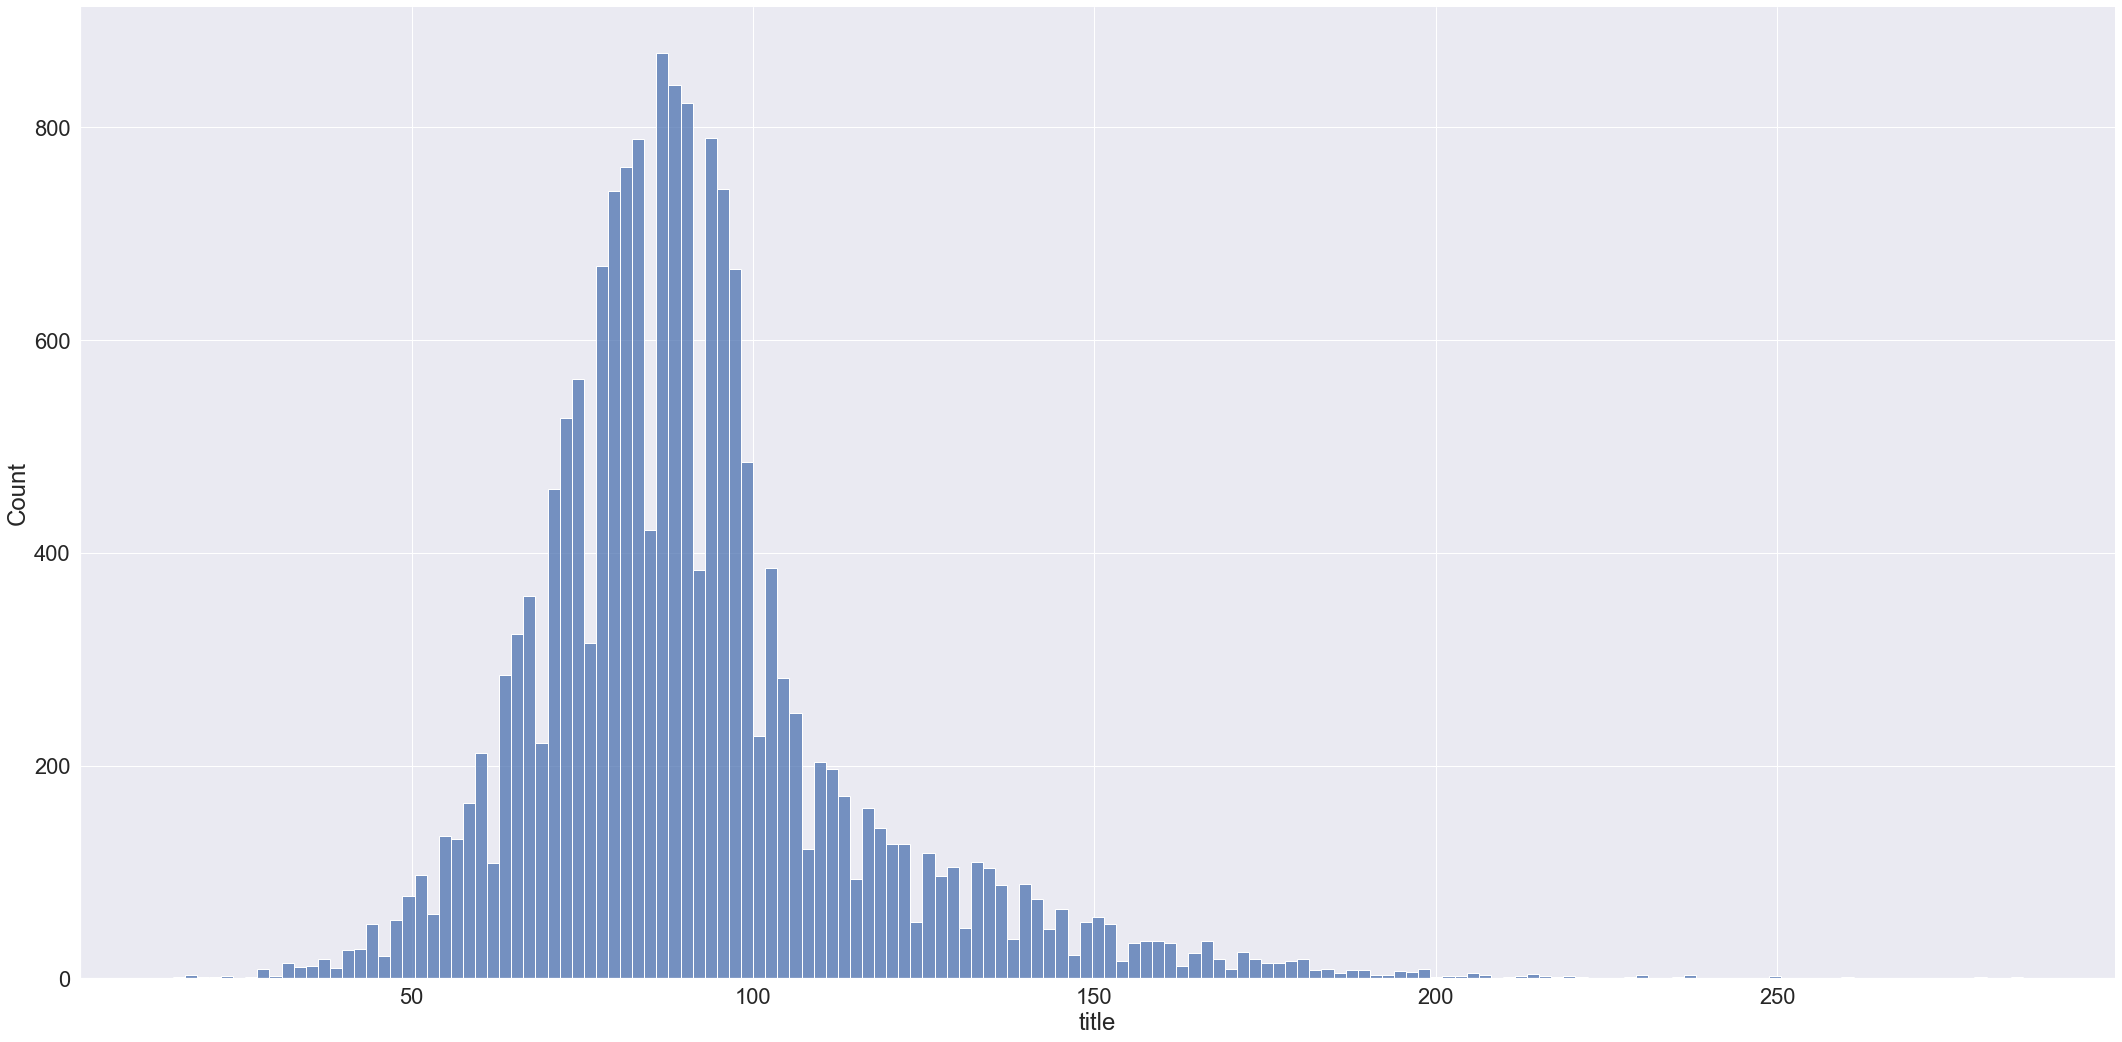

In [39]:
sns.displot(fake_title_len,height=15, aspect=2)

In [ ]:
"""

Conclusion - 

"""

In [ ]:
#Check number of words in text , Fake v. True
Woord counter

In [ ]:
#Unique Word occurance Counter

In [ ]:
#Plot 



'''





Is the Fake/True data related to certian time period? 

Whats the time wise relation between true and fake data?




What words are most common in title/text asnd associated with fake/true?

-Most Frequently Used words in Title/Text
- Number of words in title
- Number of words in Text
- Number of words used in Title Vs Text


'''





In [ ]:
def clean_text():
    #Remove non-alphameric charsacters - regexx, remove brackets, http, puncutations, stop words
    pass

In [ ]:
## Data Exploration
# Plot not text plotting - 
#Plot frequency and check and find relations between features and use in model

## Data Preparation

In [ ]:
df['text'] = df['title'] + " " +  df['text'] 
del df['title'], df['subject'], df['date']

In [ ]:

"""
# Make Lowercase 

# Remove Non-Numeric data

# Tokenization

# Remove Stop words


# Word Lemmatization
"""

"""
# Train Test Split

#Bag Of Words - Builds Vocab from text and counts frequence of occurance of word in documment


"""


# Tokenization
vocab = 10000
tokenizer = Tokenizer(num_words = vocab)
tokenizer.fit_on_texts(X_train)
X = tokenizer.texts_to_sequences(X_train)



# Stopwords 
stop = set(stopwords.words('english'))

# Punctuation
punctuation = list(string.punctuation)
stop.update(punctuation)




In [ ]:


## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=10000, ngram_range=(1,2))

vectorizer.fit(corpus)


X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_



In [ ]:
# Word Vectorization:



#- Count Vectorizer 
#- Word2Vec

In [ ]:
# ML Models


# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)

# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)






In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

In [ ]:
# Neural Network

In [ ]:
## Feature Engineering


#Drop Date
#Tokenize
#Stemmer
#Stop Words
#Convert to vectors
#One Hot Encode


#Pre process 
vocab_size = 10000
corpus = []
ps = PorterStemmer() ## used for standardization of words

for i in range(0,len(news_data_final)):
    message = re.sub('[^a-zA-Z]',' ',news_data_final['title'][i]) ## except a-z and A-Z all charectors will be replaced by space
    message = message.lower() ## then make every words in lower
    message = message.split() ## then split every words in list
    
    message = [ps.stem(word) for word in message if not word in stoplist] ## use stem to stem words which are not in stoplist
    message = ' '.join(message) ## then join those words to make the full sentence as a list 
    corpus.append(message) ## then append all the sentences in the corpus
    
    
    



In [ ]:
# Remove Stop words

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

In [ ]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(final_data)):
    review = re.sub('[^a-zA-Z]', ' ', final_data['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [ ]:
#BOW to vectorize sentence
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(X_train)
X_test  = vectorizer.transform(X_test)

In [ ]:
# Train Test Split
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3)
X_train = train.drop('y', axis=1)
y_train = train['y']
X_test = test.drop('y', axis=1)
y_test = test['y']



In [ ]:
y_train.value_counts()

## Model Init

In [ ]:
#Models
#SVM
# Naive Bayes

# Transformers / LSTM RNN smtn


In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print('Accuracy for {} data: {:.4f}'.format(source, score))

In [ ]:
from tensorflow.keras.layers import Embedding,Dense,LSTM,Dropout
from tensorflow.keras.models import Sequential

## Creating mod
embedding_vector_features=40
model=Sequential()
model.add(Embedding(vocab_size,embedding_vector_features,input_length=20)) ## embedding layer used 40 features to make feature representation of the sentences
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3)) ## drop out layer to make the model more regularized
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary()) ## model architechture done

In [ ]:
model = Sequential()
model.add(Embeding())
